In [43]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import recommendations
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

In [44]:
df = pd.read_csv('../datasets/SEHIR/processed_dataset.csv')
df = df[['Student Number', 'Course Code', 'Letter Grade', 'Semester', 'Course Credit', 'GPA', 'Completed Credits', 'Department Code']]
df

,Student Number,Course Code,Letter Grade,Semester,Course Credit,GPA,Completed Credits,Department Code
0,240,UNI 111,F,2011 - Fall,3,2.62,18,SOC
1,338,UNI 107,A,2011 - Fall,3,3.68,18,PSY
2,338,UNI 105,A,2011 - Fall,3,3.68,18,PSY
3,338,UNI 103,A,2011 - Fall,3,3.68,18,PSY
4,240,UNI 105,A,2011 - Fall,3,2.62,18,SOC
...,...,...,...,...,...,...,...,...
48736,1102,MGT 531,A-,2014 - Spring,3,3.80,24,MBA/NT
48737,1102,MGT 585,A,2014 - Spring,3,3.80,24,MBA/NT
48738,1102,MGT 552,A,2014 - Spring,3,3.80,24,MBA/NT
48739,1984,MGT 574,A-,2014 - Spring,3,3.20,24,MBA/NT


In [45]:
df = pd.concat([df, pd.get_dummies(df['Department Code'], prefix='Department Code')], axis=1)
df.drop(['Department Code'], axis=1, inplace=True)

In [46]:
numerical_grades = {'A+': 4.1, 'A': 4.0, 'A-': 3.7, 'B+': 3.3, 'B': 3.0, 'B-': 2.7, 'C+': 2.3, 'C': 2.0,
                    'C-': 1.7, 'D+': 1.3, 'D': 1.0, 'D-': 0.5, 'F': 0.0}

In [47]:
course_credits = {}
for row_idx in df.index:
    course_code = df.iloc[row_idx, 1]
    credit = df.iloc[row_idx, 4]    
    course_credits[course_code] = credit

In [48]:
def get_semester_data(semester_name):
    semester_data = {}   # semester data in shape {student_number: {course_code: letter_grade, ...}, ...}
    
    # extracting the instances with the given semester_name from the main dataFrame
    dataset = df[df.iloc[:, 3] == semester_name]
    dataset.index = range(len(dataset))
    
    # filling the semester_data dictionary
    for row_idx in dataset.index:
        student_number = dataset.iloc[row_idx, 0]
        course_code = dataset.iloc[row_idx, 1]
        letter_grade = dataset.iloc[row_idx, 2]
        
        semester_data.setdefault(student_number, {})
        semester_data[student_number][course_code] = numerical_grades[letter_grade]
    
    return semester_data

In [49]:
def get_avg_gpa(train_semester, student):
    courses = train_semester[student]
    total_credit = 0
    weights = 0
    for course in courses:
        total_credit += course_credits[course]
        weights += courses[course] * course_credits[course]
    
    return weights / total_credit

In [50]:
def get_grade_stats(semester_data, student):
    grade_list = []
    
    for course in semester_data[student]:
        numerical_grade = semester_data[student][course]
        grade_list.append(numerical_grade)
    
    mean = np.mean(grade_list)
    std_dev = np.std(grade_list)
    
    return mean, std_dev

### elbow inertia method for selecting optimal k value 

In [51]:
def elbow_inertia(train_sems, cluster_model, k_range=range(10, 31, 5)):
    train_dataset = pd.DataFrame(columns=df.columns)

    # build training dataset (same as fit_cluster)
    for sem in train_sems:
        train_dataset = pd.concat(
            [train_dataset, df[df.iloc[:, 3] == sem]],
            ignore_index=True
        )

    cluster_features = train_dataset[['GPA', 'Completed Credits'] +
                                     list(train_dataset.columns[7:])]

    inertias = []

    for k in k_range:
        kmeans = cluster_model(
            n_clusters=k,
            random_state=42,
            n_init=10
        )
        kmeans.fit(cluster_features)
        inertias.append(kmeans.inertia_)

    return list(k_range), inertias

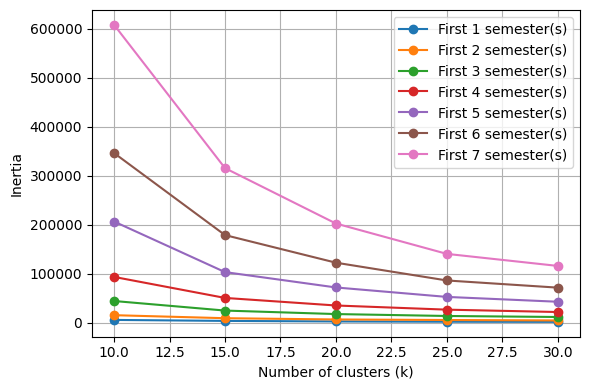

In [52]:
sorted_semesters = sorted(set(df.iloc[:, 3]))
k_range = range(10, 31, 5)

all_inertias = {}  # {n: (k_vals, inertias)}

for n in range(1, 8):   # first n semesters
    training_semesters = sorted_semesters[:n]

    k_vals, inertias = elbow_inertia(
        training_semesters,
        KMeans,
        k_range=k_range
    )

    all_inertias[n] = inertias


# Plot elbow
plt.figure(figsize=(6, 4))

for n, inertias in all_inertias.items():
    plt.plot(
        k_vals,
        inertias,
        marker='o',
        label=f'First {n} semester(s)'
    )

plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
# plt.title("Elbow Method for Different Training Semester Sizes")
plt.legend()
plt.grid(True)
plt.tight_layout()

# plt.savefig('elbow_method.eps', bbox_inches='tight')
plt.show()

### Scarsity Ratio

In [53]:
cols = ['GPA', 'Completed Credits'] + list(df.columns[7:])
scar = df[cols]
print(f"Scarsity = {scar.eq(False).sum().sum() / (df[cols].shape[0] * df[cols].shape[1]) * 100}%")

Scarsity = 91.44727085146856%


In [54]:
def fit_cluster(train_sems, num_clusters, training_data, cluster_model):
    train_dataset = pd.DataFrame(columns=df.columns)
    
    # extracting instances from the dataset which should be in training data
    for sem in train_sems:
        train_dataset = pd.concat([train_dataset, df[df.iloc[:, 3] == sem]], ignore_index=True)

    cluster_features = train_dataset[['GPA', 'Completed Credits'] + list(train_dataset.columns[7:])]
    
    # fitting a clustering model based on GPA, Completed Credits and Departments
    fitted_cluster_model = cluster_model(n_clusters=num_clusters).fit(cluster_features)
    cluster_labels = fitted_cluster_model.labels_

    # Silhouette metrics
    sil_score = silhouette_score(cluster_features, cluster_labels)

    sil_samples = silhouette_samples(cluster_features, cluster_labels)
    cluster_silhouette = {}

    for lbl in np.unique(cluster_labels):
        cluster_silhouette[lbl] = sil_samples[cluster_labels == lbl].mean()
    
    cluster_dataset = {}   # splitting the train dataset into sub-dicts based on their predicted cluster label
    
    # assigning each students' data to their predicted clusters
    for i in range(len(cluster_labels)):
        cluster_dataset.setdefault(cluster_labels[i], {})
        student_number = train_dataset.iloc[i, 0]
        cluster_dataset[cluster_labels[i]][student_number] = training_data[student_number]
    
    return cluster_dataset, fitted_cluster_model, sil_score, cluster_silhouette

In [55]:
def cluster_test_data(cluster_model, semester_name):
    # extracting all instances with the given semester_name from the main dataFrame
    test_dataset = df[df.iloc[:, 3] == semester_name]
    test_dataset.index = range(len(test_dataset))
    
    # predicting the cluster labels of test data using a cluster model fitted on the train data so far
    cluster_features = test_dataset[['GPA', 'Completed Credits'] + list(test_dataset.columns[7:])]
    cluster_labels = cluster_model.predict(cluster_features)
    
    # getting the semester data of available students in test semester
    semester_data = get_semester_data(semester_name)
    
    cluster_dataset = {}   # splitting the test dataset into sub-dicts based on their predicted cluster label
    
    # assigning each students' data to their predicted clusters
    for i in range(len(cluster_labels)):
        cluster_dataset.setdefault(cluster_labels[i], {})
        student_number = test_dataset.iloc[i, 0]
        cluster_dataset[cluster_labels[i]][student_number] = semester_data[student_number]
        
    return cluster_dataset    

In [56]:
def get_course_stats(train_semester):
    course_grades = {}
    all_grades = []
    for student, courses in train_semester.items():
        for course, grade in courses.items():
            course_grades.setdefault(course, []).append(grade)
            all_grades.append(grade)
    course_means = {c: np.mean(g) for c, g in course_grades.items()}
    global_mean = np.mean(all_grades) if all_grades else 0
    return course_means, global_mean

In [57]:
def get_errors(train_semester, test_semester, sim, item_based, sim_matrix=None, model_type='local'):
    average_gpa = {}
    y_true = []
    y_pred = []
    sources = []  # <--- YENİ: Kaynakları tutacak liste
    gpa = {}
    
    # 1. GPA Hazırlığı
    for student in train_semester:
        gpa[student] = get_avg_gpa(train_semester, student)
        average_gpa[student] = gpa[student]

    # 2. Benzerlik Matrisi
    current_sims = sim_matrix
    if item_based and current_sims is None:
        current_sims = recommendations.calculateSimilarItems(train_semester)

    # 3. Tahmin Döngüsü
    for student in train_semester:
        if student not in test_semester: continue

        # --- CF ÖNERİLERİ ---
        recommended_courses = {}
        if item_based:
            recs = recommendations.getRecommendedItems(train_semester, current_sims, student)
        else:
            recs = recommendations.getRecommendations(train_semester, student, sim, dgpa=True, gpa=gpa, delta=0.7)
        
        for rec_grade, rec_course in recs:
            recommended_courses[rec_course] = rec_grade
            
        mean, std_dev = get_grade_stats(train_semester, student)
            
        for course_code in test_semester[student]:
            final_pred = None
            source_tag = "" # <--- Etiket
            
            # DURUM 1: CF Tahmini (Local veya Global)
            if course_code in recommended_courses:
                final_pred = recommended_courses[course_code]
                source_tag = "CF" # (İstersen f"{model_type}_CF" diyerek Local/Global ayırabilirsin)
            
            # DURUM 2: Fallback (GPA)
            else:
                final_pred = average_gpa[student]
                source_tag = "Fallback"

            # Outlier Kontrolü
            if std_dev > 0:
                if final_pred < mean - (2 * std_dev) or final_pred > mean + (2 * std_dev):
                    continue
            
            y_pred.append(final_pred)
            y_true.append(test_semester[student][course_code])
            sources.append(source_tag) # <--- Kaynağı kaydet
            
    return y_true, y_pred, sources # <--- 3 değer döndür

In [58]:
def analyze_cluster_sizes(cluster_dataset, k, threshold=190):
    """
    Her bir kümedeki öğrenci sayısını hesaplar ve 190 altı durumu raporlar.
    """
    sizes = []
    # cluster_dataset yapısı: {cluster_label: {student_id: data, ...}}
    for label in sorted(cluster_dataset.keys()):
        count = len(cluster_dataset[label])
        sizes.append(count)
    
    min_size = min(sizes) if sizes else 0
    max_size = max(sizes) if sizes else 0
    avg_size = sum(sizes) / len(sizes) if sizes else 0
    
    # 190'dan küçük olanları bul
    under_threshold = [s for s in sizes if s < threshold]
    
    print(f"\n--- Cluster Size Analysis (K={k}) ---")
    print(f"Sizes: {sizes}")
    print(f"MIN Size: {min_size} | MAX Size: {max_size} | AVG: {avg_size:.1f}")
    
    if under_threshold:
        print(f"⚠️ UYARI: {len(under_threshold)} adet cluster {threshold}'dan küçük! -> {under_threshold}")
    else:
        print(f"✅ Başarılı: Tüm clusterlar {threshold}'dan büyük.")
        
    return sizes, min_size

In [60]:
def predict(sim, cluster_model, item_based=False, threshold=190):
    predictions = {}
    sorted_semesters = sorted(set(df.iloc[:, 3])) 
    
    for num_clusters in range(10, 31, 5):
        print(f"\n---> Running Adaptive Framework for k={num_clusters}...")
        predictions.setdefault(str(num_clusters), {})
        
        silhouette_list = []
        train_semester = {}
        
        for sem_idx in range(1, len(sorted_semesters)):
            # --- YENİ: sources listesi eklendi ---
            predictions[str(num_clusters)].setdefault(str(sem_idx), {'y_true': [], 'y_pred': [], 'sources': []})
            
            new_semester = get_semester_data(sorted_semesters[sem_idx-1])
            for student in new_semester:
                if student in train_semester:
                    train_semester[student].update(new_semester[student])
                else:
                    train_semester[student] = new_semester[student]
            
            # Phase 2: Global Sim
            global_sims = None
            if item_based:
                global_sims = recommendations.calculateSimilarItems(train_semester)
            
            # Phase 1: Clustering
            training_semesters_name = sorted_semesters[:sem_idx]
            train_cluster_data, fitted_cluster_model, sil_score, _ = fit_cluster(
                training_semesters_name, num_clusters, train_semester, cluster_model
            )
            
            test_semester_name = sorted_semesters[sem_idx]
            test_cluster_data = cluster_test_data(fitted_cluster_model, test_semester_name)
            
            # Phase 3: Adaptive Inference
            for cluster_label in train_cluster_data:
                if cluster_label not in test_cluster_data: continue
                
                cluster_size = len(train_cluster_data[cluster_label])
                
                # Değişkenleri hazırla
                current_y_true, current_y_pred, current_sources = [], [], []

                if cluster_size < threshold:
                    # GLOBAL MODEL (Sparse Cluster)
                    current_y_true, current_y_pred, current_sources = get_errors(
                        train_semester,          
                        test_cluster_data[cluster_label], 
                        sim, item_based, 
                        sim_matrix=global_sims,
                        model_type='global' # İstatistik için not düşüyoruz
                    )
                else:
                    # LOCAL MODEL (Dense Cluster)
                    current_y_true, current_y_pred, current_sources = get_errors(
                        train_cluster_data[cluster_label], 
                        test_cluster_data[cluster_label], 
                        sim, item_based, 
                        sim_matrix=None,
                        model_type='local'
                    )
                
                # --- SONUÇLARI BİRLEŞTİR ---
                predictions[str(num_clusters)][str(sem_idx)]['y_true'] += current_y_true
                predictions[str(num_clusters)][str(sem_idx)]['y_pred'] += current_y_pred
                predictions[str(num_clusters)][str(sem_idx)]['sources'] += current_sources # <--- EKLENDİ

            print(f"  Sem {sem_idx} Done. Silhouette Score: {sil_score:.3f}")

            silhouette_list.append(sil_score)

        print(f"\nMean Silhouette Scores for k={num_clusters}: {np.mean(silhouette_list):.3f}")

    return predictions

### User-based Collaborative Filtering

In [61]:
model_predictions = {}

In [62]:
predictions = predict(recommendations.sim_distance, KMeans)
model_predictions['Euclidean Distance'] = predictions


---> Running Adaptive Framework for k=10...
  Sem 1 Done. Silhouette Score: 0.484
  Sem 2 Done. Silhouette Score: 0.462
  Sem 3 Done. Silhouette Score: 0.440
  Sem 4 Done. Silhouette Score: 0.484
  Sem 5 Done. Silhouette Score: 0.453
  Sem 6 Done. Silhouette Score: 0.498
  Sem 7 Done. Silhouette Score: 0.507

Mean Silhouette Scores for k=10: 0.475

---> Running Adaptive Framework for k=15...
  Sem 1 Done. Silhouette Score: 0.454
  Sem 2 Done. Silhouette Score: 0.451
  Sem 3 Done. Silhouette Score: 0.421
  Sem 4 Done. Silhouette Score: 0.455
  Sem 5 Done. Silhouette Score: 0.446
  Sem 6 Done. Silhouette Score: 0.472
  Sem 7 Done. Silhouette Score: 0.459

Mean Silhouette Scores for k=15: 0.451

---> Running Adaptive Framework for k=20...
  Sem 1 Done. Silhouette Score: 0.383
  Sem 2 Done. Silhouette Score: 0.431
  Sem 3 Done. Silhouette Score: 0.469
  Sem 4 Done. Silhouette Score: 0.443
  Sem 5 Done. Silhouette Score: 0.443
  Sem 6 Done. Silhouette Score: 0.453
  Sem 7 Done. Silhouette 

In [63]:
predictions = predict(recommendations.sim_jaccard, KMeans)
model_predictions['Jaccard Index'] = predictions


---> Running Adaptive Framework for k=10...
  Sem 1 Done. Silhouette Score: 0.464
  Sem 2 Done. Silhouette Score: 0.444
  Sem 3 Done. Silhouette Score: 0.454
  Sem 4 Done. Silhouette Score: 0.489
  Sem 5 Done. Silhouette Score: 0.477
  Sem 6 Done. Silhouette Score: 0.531
  Sem 7 Done. Silhouette Score: 0.490

Mean Silhouette Scores for k=10: 0.479

---> Running Adaptive Framework for k=15...
  Sem 1 Done. Silhouette Score: 0.459
  Sem 2 Done. Silhouette Score: 0.451
  Sem 3 Done. Silhouette Score: 0.466
  Sem 4 Done. Silhouette Score: 0.435
  Sem 5 Done. Silhouette Score: 0.460
  Sem 6 Done. Silhouette Score: 0.454
  Sem 7 Done. Silhouette Score: 0.475

Mean Silhouette Scores for k=15: 0.457

---> Running Adaptive Framework for k=20...
  Sem 1 Done. Silhouette Score: 0.390
  Sem 2 Done. Silhouette Score: 0.429
  Sem 3 Done. Silhouette Score: 0.465
  Sem 4 Done. Silhouette Score: 0.392
  Sem 5 Done. Silhouette Score: 0.425
  Sem 6 Done. Silhouette Score: 0.448
  Sem 7 Done. Silhouette 

In [64]:
predictions = predict(recommendations.sim_pearson, KMeans)
model_predictions['Pearson Correlation'] = predictions


---> Running Adaptive Framework for k=10...
  Sem 1 Done. Silhouette Score: 0.462
  Sem 2 Done. Silhouette Score: 0.470
  Sem 3 Done. Silhouette Score: 0.472
  Sem 4 Done. Silhouette Score: 0.487
  Sem 5 Done. Silhouette Score: 0.488
  Sem 6 Done. Silhouette Score: 0.489
  Sem 7 Done. Silhouette Score: 0.496

Mean Silhouette Scores for k=10: 0.481

---> Running Adaptive Framework for k=15...
  Sem 1 Done. Silhouette Score: 0.463
  Sem 2 Done. Silhouette Score: 0.411
  Sem 3 Done. Silhouette Score: 0.410
  Sem 4 Done. Silhouette Score: 0.449
  Sem 5 Done. Silhouette Score: 0.436
  Sem 6 Done. Silhouette Score: 0.443
  Sem 7 Done. Silhouette Score: 0.438

Mean Silhouette Scores for k=15: 0.436

---> Running Adaptive Framework for k=20...
  Sem 1 Done. Silhouette Score: 0.398
  Sem 2 Done. Silhouette Score: 0.431
  Sem 3 Done. Silhouette Score: 0.441
  Sem 4 Done. Silhouette Score: 0.472
  Sem 5 Done. Silhouette Score: 0.436
  Sem 6 Done. Silhouette Score: 0.423
  Sem 7 Done. Silhouette 

In [65]:
with open('clustering_user_based_collaborative_filtering_results (Student based with KMeans).json', 'w') as fw:
    json.dump(model_predictions, fw)

### Item-based Collaborative Filtering

In [66]:
model_predictions = {}

In [67]:
predictions = predict(recommendations.sim_distance, KMeans, item_based=True)
model_predictions['Euclidean Distance'] = predictions


---> Running Adaptive Framework for k=10...
  Sem 1 Done. Silhouette Score: 0.462
  Sem 2 Done. Silhouette Score: 0.470
  Sem 3 Done. Silhouette Score: 0.461
  Sem 4 Done. Silhouette Score: 0.464
  Sem 5 Done. Silhouette Score: 0.496
  Sem 6 Done. Silhouette Score: 0.464
  Sem 7 Done. Silhouette Score: 0.490

Mean Silhouette Scores for k=10: 0.473

---> Running Adaptive Framework for k=15...
  Sem 1 Done. Silhouette Score: 0.458
  Sem 2 Done. Silhouette Score: 0.478
  Sem 3 Done. Silhouette Score: 0.474
  Sem 4 Done. Silhouette Score: 0.435
  Sem 5 Done. Silhouette Score: 0.463
  Sem 6 Done. Silhouette Score: 0.447
  Sem 7 Done. Silhouette Score: 0.474

Mean Silhouette Scores for k=15: 0.461

---> Running Adaptive Framework for k=20...
  Sem 1 Done. Silhouette Score: 0.400
  Sem 2 Done. Silhouette Score: 0.432
  Sem 3 Done. Silhouette Score: 0.432
  Sem 4 Done. Silhouette Score: 0.425
  Sem 5 Done. Silhouette Score: 0.449
  Sem 6 Done. Silhouette Score: 0.440
  Sem 7 Done. Silhouette 

In [68]:
predictions = predict(recommendations.sim_jaccard, KMeans, item_based=True)
model_predictions['Jaccard Index'] = predictions


---> Running Adaptive Framework for k=10...
  Sem 1 Done. Silhouette Score: 0.508
  Sem 2 Done. Silhouette Score: 0.463
  Sem 3 Done. Silhouette Score: 0.466
  Sem 4 Done. Silhouette Score: 0.421
  Sem 5 Done. Silhouette Score: 0.459
  Sem 6 Done. Silhouette Score: 0.494
  Sem 7 Done. Silhouette Score: 0.534

Mean Silhouette Scores for k=10: 0.478

---> Running Adaptive Framework for k=15...
  Sem 1 Done. Silhouette Score: 0.384
  Sem 2 Done. Silhouette Score: 0.437
  Sem 3 Done. Silhouette Score: 0.413
  Sem 4 Done. Silhouette Score: 0.442
  Sem 5 Done. Silhouette Score: 0.456
  Sem 6 Done. Silhouette Score: 0.459
  Sem 7 Done. Silhouette Score: 0.454

Mean Silhouette Scores for k=15: 0.435

---> Running Adaptive Framework for k=20...
  Sem 1 Done. Silhouette Score: 0.421
  Sem 2 Done. Silhouette Score: 0.454
  Sem 3 Done. Silhouette Score: 0.465
  Sem 4 Done. Silhouette Score: 0.448
  Sem 5 Done. Silhouette Score: 0.451
  Sem 6 Done. Silhouette Score: 0.423
  Sem 7 Done. Silhouette 

In [69]:
predictions = predict(recommendations.sim_pearson, KMeans, item_based=True)
model_predictions['Pearson Correlation'] = predictions


---> Running Adaptive Framework for k=10...
  Sem 1 Done. Silhouette Score: 0.467
  Sem 2 Done. Silhouette Score: 0.468
  Sem 3 Done. Silhouette Score: 0.457
  Sem 4 Done. Silhouette Score: 0.484
  Sem 5 Done. Silhouette Score: 0.489
  Sem 6 Done. Silhouette Score: 0.490
  Sem 7 Done. Silhouette Score: 0.489

Mean Silhouette Scores for k=10: 0.477

---> Running Adaptive Framework for k=15...
  Sem 1 Done. Silhouette Score: 0.505
  Sem 2 Done. Silhouette Score: 0.494
  Sem 3 Done. Silhouette Score: 0.464
  Sem 4 Done. Silhouette Score: 0.457
  Sem 5 Done. Silhouette Score: 0.455
  Sem 6 Done. Silhouette Score: 0.447
  Sem 7 Done. Silhouette Score: 0.477

Mean Silhouette Scores for k=15: 0.471

---> Running Adaptive Framework for k=20...
  Sem 1 Done. Silhouette Score: 0.396
  Sem 2 Done. Silhouette Score: 0.433
  Sem 3 Done. Silhouette Score: 0.380
  Sem 4 Done. Silhouette Score: 0.453
  Sem 5 Done. Silhouette Score: 0.425
  Sem 6 Done. Silhouette Score: 0.436
  Sem 7 Done. Silhouette 

In [70]:
with open('clustering_item_based_collaborative_filtering_results (Student based with KMeans).json', 'w') as fw:
    json.dump(model_predictions, fw)

### analyze coverage ratio of collaborative filtering algorithm (done for best model which is Euclidean Distance item based k=15)

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

def analyze_coverage_and_rmse_gap(predictions_dict, k_value='20'):
    """
    CF ve Fallback performansını kıyaslar.
    Makaledeki '???' boşluklarını doldurur.
    """
    # print(f"\n--- DETAILED ANALYSIS FOR k={k_val} ---")
    
    semesters = predictions_dict[k_value]
    
    all_true = []
    all_pred = []
    all_sources = []
    
    # Tüm dönem verilerini tek havuzda topla
    for sem in semesters:
        all_true.extend(semesters[sem]['y_true'])
        all_pred.extend(semesters[sem]['y_pred'])
        all_sources.extend(semesters[sem]['sources'])
        
    total_count = len(all_sources)
    if total_count == 0: return

    # Gruplara Ayır
    cf_indices = [i for i, s in enumerate(all_sources) if s == 'CF']
    fallback_indices = [i for i, s in enumerate(all_sources) if s == 'Fallback']
    
    # 1. COVERAGE HESABI
    cf_count = len(cf_indices)
    fallback_count = len(fallback_indices)
    coverage_ratio = (cf_count / total_count) * 100
    
    print(f"Total Predictions: {total_count}")
    print(f"CF Predictions:    {cf_count} ({coverage_ratio:.2f}%)")
    print(f"Fallback (GPA):    {fallback_count} ({100-coverage_ratio:.2f}%)")
    print("-" * 30)
    
    # 2. RMSE KIYASLAMASI (Value beyond simple GPA)
    cf_rmse = 0
    fallback_rmse = 0
    rmse_diff = 0
    
    if cf_indices:
        y_true_cf = [all_true[i] for i in cf_indices]
        y_pred_cf = [all_pred[i] for i in cf_indices]
        cf_rmse = np.sqrt(mean_squared_error(y_true_cf, y_pred_cf))
        print(f"✅ CF Model RMSE:      {cf_rmse:.4f}")
        
    if fallback_indices:
        y_true_fb = [all_true[i] for i in fallback_indices]
        y_pred_fb = [all_pred[i] for i in fallback_indices]
        fallback_rmse = np.sqrt(mean_squared_error(y_true_fb, y_pred_fb))
        print(f"⚠️ Fallback (GPA) RMSE: {fallback_rmse:.4f}")
        
    if cf_indices and fallback_indices:
        rmse_diff = fallback_rmse - cf_rmse
        print("-" * 30)
        print(f"RESULT: Fallback error is higher by {rmse_diff:.4f}")
        print(f"PROOF: CF reduces error by {(rmse_diff/fallback_rmse)*100:.1f}% compared to GPA extrapolation.")

# --- KULLANIM ---
# predictions = predict(...) kodunu çalıştırdıktan sonra:
# select the model and k value you want to analyze, for example:
analyze_coverage_and_rmse_gap(model_predictions['Euclidean Distance'], k_value='15')

### student based with no fallback algorithm (produce subset and results json files)

In [30]:
def generate_coverage_mask_and_save_results(sim, cluster_model, best_k, item_based=True, threshold=190):
    coverage_mask = {} 
    semester_rmse_list = []
    semester_mae_list = []
    
    sorted_semesters = sorted(set(df.iloc[:, 3]))
    print(f"Generating Adaptive Mask (Local + Global CF) using k={best_k}, threshold={threshold}...")
    
    train_semester = {} # Global Veri Havuzu
    
    for sem_idx in range(1, len(sorted_semesters)):
        current_sem_name = sorted_semesters[sem_idx]
        coverage_mask[current_sem_name] = {}
        
        current_sem_y_true = []
        current_sem_y_pred = []
        
        # 1. Global Training Verisini Güncelle
        new_semester = get_semester_data(sorted_semesters[sem_idx-1])
        for student in new_semester:
            if student in train_semester:
                train_semester[student].update(new_semester[student])
            else:
                train_semester[student] = new_semester[student]
        
        # Global Benzerlik Matrisi (Her dönem başında 1 kere hesapla - Hız için)
        global_sims = None
        if item_based:
            global_sims = recommendations.calculateSimilarItems(train_semester)
        
        # 2. Modeli Eğit ve Kümele
        training_semesters_name = sorted_semesters[:sem_idx]
        train_cluster_data, fitted_cluster_model, _, _ = fit_cluster(training_semesters_name, best_k, train_semester, cluster_model)
        test_cluster_data = cluster_test_data(fitted_cluster_model, current_sem_name)
        
        # 3. Kümeleri Gez
        for cluster_label in train_cluster_data:
            if cluster_label not in test_cluster_data:
                continue
            
            cluster_train = train_cluster_data[cluster_label]
            cluster_test = test_cluster_data[cluster_label]
            cluster_size = len(cluster_train)
            
            # --- ADAPTIVE KARAR MEKANİZMASI (YENİ KISIM) ---
            used_data = None
            used_sims = None
            
            if cluster_size < threshold:
                # KÜÇÜK KÜME -> GLOBAL KULLAN
                used_data = train_semester # Tüm okul verisi
                used_sims = global_sims    # Global benzerlikler
            else:
                # BÜYÜK KÜME -> LOCAL KULLAN
                used_data = cluster_train
                # Local benzerlik o an hesaplanır
                if item_based:
                    used_sims = recommendations.calculateSimilarItems(used_data)
            
            # Öğrenci Ortalamaları (Outlier kontrolü için kendi verisi lazım)
            # Not: Outlier için her zaman öğrencinin kendi geçmişine (used_data içindeki) bakılır
            
            for student in cluster_test:
                # Öğrenci Training verisinde var mı?
                if student not in used_data: 
                    continue # Cold Start (Yeni öğrenci) - Pas geç
                
                # Tahmin Üret
                try:
                    if item_based:
                        recs = recommendations.getRecommendedItems(used_data, used_sims, student)
                    else:
                        # User-based mantığı (Global/Local veriye göre)
                        gpa_local = {s: get_avg_gpa(used_data, s) for s in used_data}
                        recs = recommendations.getRecommendations(used_data, student, sim, dgpa=True, gpa=gpa_local, delta=0.7)
                except KeyError: 
                    continue
                
                recommended_courses = {r[1]: r[0] for r in recs}
                
                # Outlier Stats (Öğrencinin kendi geçmişine göre)
                mean, std_dev = get_grade_stats(used_data, student)

                for course_code in cluster_test[student]:
                    # --- MASKE KONTROLÜ ---
                    # Eğer CF (Local veya Global) bir tahmin ürettiyse listeye al.
                    # Üretmediyse (Fallback/GPA durumu) LİSTEYE ALMA.
                    
                    if course_code in recommended_courses:
                        rec_grade = recommended_courses[course_code]
                        
                        # Outlier Kontrolü
                        if not (rec_grade < mean - (2 * std_dev) or rec_grade > mean + (2 * std_dev)):
                            
                            # TAHMİN BAŞARILI -> MASKEYE EKLE
                            if str(student) not in coverage_mask[current_sem_name]:
                                coverage_mask[current_sem_name][str(student)] = []
                            coverage_mask[current_sem_name][str(student)].append(course_code)
                            
                            current_sem_y_true.append(cluster_test[student][course_code])
                            current_sem_y_pred.append(rec_grade)
        
        # --- Dönem Sonu ---
        if len(current_sem_y_true) > 0:
            sem_rmse = np.sqrt(mean_squared_error(current_sem_y_true, current_sem_y_pred))
            sem_mae = mean_absolute_error(current_sem_y_true, current_sem_y_pred)
            semester_rmse_list.append(sem_rmse)
            semester_mae_list.append(sem_mae)

    final_rmse = np.mean(semester_rmse_list)
    final_mae = np.mean(semester_mae_list)
    
    return coverage_mask, final_rmse, final_mae

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
# 1. En iyi k değerini buraya yaz (15 veya 20, hangisi RMSE'de düşük çıktıysa)
WINNING_K = 15  
THRESHOLD = 190 # Algoritmanın karar sınırı

mask_data, subset_rmse, subset_mae = generate_coverage_mask_and_save_results(
    recommendations.sim_distance, # Euclidean
    KMeans, 
    best_k=WINNING_K, 
    item_based=True,
    threshold=THRESHOLD # <--- YENİ EKLENEN PARAMETRE
)

# --- KAYDETME ---
with open('subset_fallback_mask.json', 'w') as f:
    json.dump(mask_data, f)

subset_results = {
    'Model': 'Adaptive Framework (Local + Global) - No Fallback', # İsmi güncelledim
    'RMSE': subset_rmse,
    'MAE': subset_mae,
    'Calculation': 'Mean of Semester Scores (Same as original)'
}

with open('subset_fallback_results_for_cf_student_based.json', 'w') as f:
    json.dump(subset_results, f)

print(f"Subset RMSE (No Fallback): {subset_rmse:.4f}")
print(f"Subset MAE (No Fallback):  {subset_mae:.4f}")

Generating Adaptive Mask (Local + Global CF) using k=15, threshold=190...
Subset RMSE (No Fallback): 0.9718
Subset MAE (No Fallback):  0.7406
